<a href="https://colab.research.google.com/github/zugzvangg/ML_MIPT_4sem/blob/main/pytorchtweets/tweetspytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Предсказание тега твиттов по тексту с помощью NLP на pytorch

В начальном файле были оставлены только текст твитта и целевая метрика без удаления эмодзи, знаков препинания и прочего шума, который мы чистили, решая задачу с помощью классических методов NLP. 

In [6]:
import torch
from sklearn.model_selection import KFold
from torchtext.legacy import data
import numpy as np  
import torch.optim as optim
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(include_lengths = True,
                  tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField()
from google.colab import drive
drive.mount('/content/drive')
import random

fields = {"airline_sentiment": ('label', LABEL), "text":('text', TEXT) }
train_data= data.TabularDataset.splits(
                                        path = '/content/drive/MyDrive/Datasets',
                                        train = "Tweets.json",
                                        format = 'json',
                                        fields = fields)[0]


Mounted at /content/drive


In [7]:
print(vars(train_data[2]))


{'label': 'neutral', 'text': ['@VirginAmerica', 'I', 'did', "n't", 'today', '...', 'Must', 'mean', 'I', 'need', 'to', 'take', 'another', 'trip', '!']}


In [8]:

TEXT.build_vocab(train_data, 
                 vectors = "fasttext.simple.300d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))
test_data = valid_data

.vector_cache/wiki.simple.vec: 293MB [00:12, 22.7MB/s]                           
100%|█████████▉| 110948/111051 [00:10<00:00, 10585.40it/s]

In [9]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True, 
    device = device)

In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        embedded = self.dropout(self.embedding(text))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        return self.fc(hidden)

In [11]:
INPUT_DIM = len(TEXT.vocab)
print(INPUT_DIM)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

19137


In [12]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [13]:
def get_weights(iterator):
  weights = torch.zeros(len(LABEL.vocab))
  for batch in iterator:
    for i in batch.label:
      weights[i.cpu().numpy()] +=1
  print(weights)
  for i in range(0, len(LABEL.vocab)):
    weights[i] = (1 / weights[i]) * 100
    weights[i] = weights[i] 
  return weights

In [14]:
print(get_weights(train_iterator))

tensor([6388., 2198., 1662.])
tensor([0.0157, 0.0455, 0.0602])


In [15]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(weight =  get_weights(train_iterator))

model = model.to(device)
criterion = criterion.to(device)

tensor([6388., 2198., 1662.])


In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
def categorical_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    y_score = top_pred.detach().cpu().numpy()
    y_true = y.view_as(top_pred).cpu().numpy()
    f1 = f1_score(y_true, y_score, average = 'weighted')
    rec = recall_score(y_true, y_score, average = 'weighted')
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return (rec, f1, acc)

In [17]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_rec = 0
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        metrics = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        acc = metrics[2]
        f1 = metrics[1]
        rec = metrics[0]
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1
        epoch_rec += rec
    epoch_acc /= len(iterator)
    epoch_f1 /= len(iterator)
    epoch_rec /= len(iterator)
    return epoch_loss / len(iterator), (epoch_rec, epoch_f1, epoch_acc)

In [18]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_rec = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.label)
            
            metrics = categorical_accuracy(predictions, batch.label)

            acc = metrics[2]
            f1 = metrics[1]
            rec = metrics[0]
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1
            epoch_rec += rec
        epoch_acc /= len(iterator)
        epoch_f1 /= len(iterator)
        epoch_rec /= len(iterator)
        
    return epoch_loss / len(iterator), (epoch_rec, epoch_f1, epoch_acc)

In [19]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
N_EPOCHS = 20

best_valid_score = float('0')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_data = train(model, train_iterator, optimizer, criterion)
    train_loss = train_data[0]
    train_score = train_data[1]
    valid_data = evaluate(model, valid_iterator, criterion)
    valid_score = valid_data[1]
    valid_loss = valid_data[0]
    end_time = time.time()
    valid_acc = float(valid_score[1])
    acc = valid_acc
    #print(float(valid_acc))
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    if acc > best_valid_score:
        best_valid_score= acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/test1.pt')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid F1: {valid_score[1]*100:.2f}% | Valid rec: {valid_score[0]*100:.2f}% | Valid acc: {valid_score[2]*100:.2f}%')
    print(f'\tTrain Loss: {train_loss:.3f} | Train F1: {train_score[1]*100:.2f}% | Train rec: {train_score[0]*100:.2f}% | Train acc: {train_score[2]*100:.2f}%')
torch.save(model.state_dict(), '/content/drive/MyDrive/test1_fin.pt')

Epoch: 01 | Epoch Time: 0m 2s
	Valid Loss: 0.802 | Valid F1: 66.83% | Valid rec: 64.69% | Valid acc: 64.69%
	Train Loss: 0.954 | Train F1: 55.34% | Train rec: 55.61% | Train acc: 55.61%
Epoch: 02 | Epoch Time: 0m 1s
	Valid Loss: 0.661 | Valid F1: 75.14% | Valid rec: 74.85% | Valid acc: 74.85%
	Train Loss: 0.732 | Train F1: 69.58% | Train rec: 68.77% | Train acc: 68.77%


100%|█████████▉| 110948/111051 [00:30<00:00, 10585.40it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Valid Loss: 0.697 | Valid F1: 77.58% | Valid rec: 77.98% | Valid acc: 77.98%
	Train Loss: 0.603 | Train F1: 75.54% | Train rec: 74.98% | Train acc: 74.98%
Epoch: 04 | Epoch Time: 0m 1s
	Valid Loss: 0.627 | Valid F1: 77.68% | Valid rec: 77.15% | Valid acc: 77.15%
	Train Loss: 0.524 | Train F1: 78.84% | Train rec: 78.27% | Train acc: 78.27%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.445 | Train F1: 81.89% | Train rec: 81.48% | Train acc: 81.48%
Epoch: 06 | Epoch Time: 0m 1s
	Valid Loss: 0.682 | Valid F1: 77.76% | Valid rec: 77.05% | Valid acc: 77.05%
	Train Loss: 0.396 | Train F1: 83.90% | Train rec: 83.59% | Train acc: 83.59%
Epoch: 07 | Epoch Time: 0m 1s
	Valid Loss: 0.722 | Valid F1: 79.66% | Valid rec: 79.43% | Valid acc: 79.43%
	Train Loss: 0.332 | Train F1: 86.44% | Train rec: 86.22% | Train acc: 86.22%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.291 | Train F1: 87.96% | Train rec: 87.82% | Train acc: 87.82%
Epoch: 09 | Epoch Time: 0m 1s
	Valid Los

Метрики на тесте:

In [24]:
model.load_state_dict(torch.load('/content/drive/MyDrive/test1.pt'))

test_data = evaluate(model, valid_iterator, criterion)
test_score = test_data[1]
test_loss = test_data[0]

print(f'\tTest Loss: {test_loss:.3f} | Test F1: {test_score[1]*100:.2f}% | Test rec: {train_score[0]*100:.2f}% | Test acc: {train_score[2]*100:.2f}%')

	Test Loss: 0.836 | Test F1: 79.84% | Test rec: 96.55% | Test acc: 96.55%


In [25]:
n_categories = len(LABEL.vocab)
confusion = np.zeros((n_categories, n_categories))
print(confusion)

model.eval()
sum = 0
with torch.no_grad():
    for batch in valid_iterator:
      text, text_lengths = batch.text
      predictions = model(text, text_lengths).squeeze(1)
      y = batch.label
      top_pred = predictions.argmax(1, keepdim = True)
      y_score = top_pred.detach().cpu().numpy()
      y_true = y.view_as(top_pred).cpu().numpy()
      for i in range(0, y_true.shape[0]):
        confusion[[y_true[i] , y_score[i]]] +=1
print(confusion)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


[[2458.  238.   94.]
 [ 232.  592.   77.]
 [  96.  144.  461.]]


Confusion matrix:

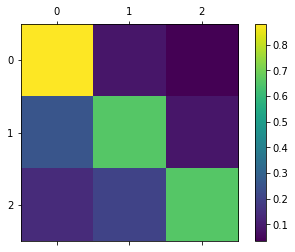

In [28]:

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
  
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
fig.colorbar(cax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()